In [44]:
import pandas as pd
import numpy as np
import xarray as xr
import requests
%matplotlib inline
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from cartopy import config
import cartopy.crs as ccrs
from shapely.geometry import Polygon
import shapely.geometry as geometry
from geojson import Polygon
import pymongo
import multiprocessing as mp
from numpy import array_split
from datetime import datetime
from datetime import timedelta

import pdb
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
from descartes import PolygonPatch
import numpy as np
import math

In [27]:
arFileName = '/storage/MERRA2.ar_tag.Guan_Waliser_v2.3hourly.1980to2017.nc4'
ds = xr.open_dataset(arFileName, decode_cf=False)

In [28]:
def make_square(point, dx, dy):
    isNeg = [ ( x > 0, y > 0) for x in range(0,2) for y in range(0, 2) ]
    sign = lambda x: 1 * x + -1 * (not x)
    square = [ (point[0] + dx/2. * sign(sx), point[1] + dy/2. * sign(sy)) for (sx, sy) in isNeg]
    return square
lat, lon = 5, 5
dlat, dlon = 1, 1
print(make_square((lon, lat), dlon, dlat))

[(4.5, 4.5), (4.5, 5.5), (5.5, 4.5), (5.5, 5.5)]


In [45]:
points = make_square((lon, lat), dlon, dlat) + make_square((lon + dlon, lat), dlon, dlat) + make_square((lon, lat+dlat), dlon, dlat)
pc = geometry.MultiPoint(list(points))
#alpha_shape(pc, .5, 0)

/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 648x432 with 0 Axes>

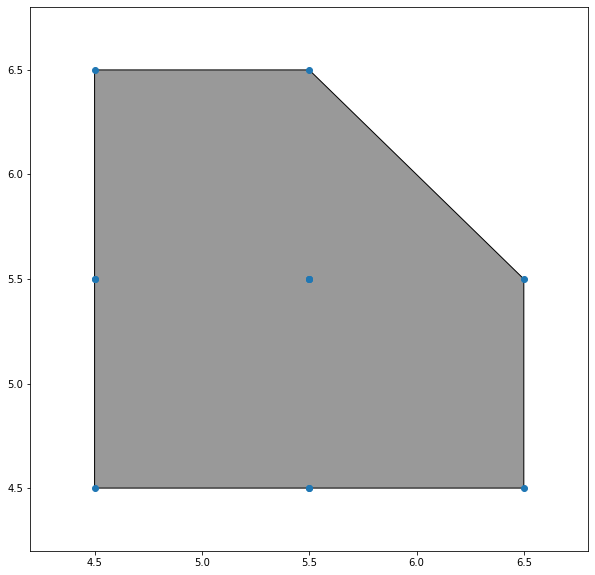

In [43]:
def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

x = [p.coords.xy[0] for p in pc]
y = [p.coords.xy[1] for p in pc]

fig = plt.figure(figsize=(9,6))
convex_hull_polygon = pc.convex_hull
plot_polygon(convex_hull_polygon)
ax = plt.axes()
ax.scatter(x, y)

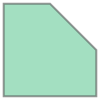

In [42]:
pc.convex_hull

In [46]:
def alpha_shape(points, alpha):
    """
    http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        aa = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        bb = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        cc = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        ss = (aa + bb + cc)/2.0
        # Area of triangle by Heron's formula
        areaSquared = ss*(ss-aa)*(ss-bb)*(ss-cc)
        if areaSquared < 0: # handles roundoff
            continue
        area = math.sqrt(areaSquared)
        try:
            area = math.sqrt(ss*(ss-aa)*(ss-bb)*(ss-cc))
        except ValueError:
            pdb.set_trace()
            continue
        if area == 0:
            continue
        circum_r = aa*bb*cc/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    concave_hull = cascaded_union(triangles)
    return concave_hull, edge_points

def get_df_outline_points(lats, lons, dlat=.5, dlon=.625):
    '''Returns outer hull of set of grid points.'''
    points = list(zip(lons, lats))
    outPoints = []
    for point in points:
        square = make_square(point, dlon, dlat)
        outPoints += square
    outPoints = list(set(outPoints))
    outLons, outLats = [[ i for i, j in outPoints ], [ j for i, j in outPoints ]] 
    return outLats, outLons
        

def get_perim_df(df, dlat=.5, dlon=.625, idx=1, alpha=.5, buffer=None):
    AR = df[ df['shape'] == idx ]
    
    ARRange = AR['lon'].max() - AR['lon'].min()
    if ARRange > 180:
        AR['lon'] = transform_long(AR['lon'].values)
        
    
    points = [geometry.Point(xy) for xy in list(zip(AR.lon, AR.lat))]
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    if isinstance(concave_hull, geometry.multipolygon.MultiPolygon):
        lat, lon = [], []
        for poly in concave_hull:
            if buffer:
                plon, plat = poly.buffer(buffer).exterior.coords.xy
            else:
                plon, plat = poly.exterior.coords.xy
            lat.extend(plat)
            lon.extend(plon)
    else:
        if buffer:
            lon, lat = concave_hull.buffer(buffer).exterior.coords.xy
        else:
            lon, lat = concave_hull.exterior.coords.xy
            
    pdf = pd.DataFrame({'lon': lon, 'lat': lat, 'shape': idx})
    return pdf

def transform_long(plon):
    '''lon > 60 are transformed to negative coords'''
    tlon = []
    for long in plon:
        if long > 60:
            tlon.append( long -  360 )
        else:
            tlon.append(long)
    return tlon

def plot_scatter(df, date):
    fig = plt.figure(figsize=(9,6))
    x = df['lon'].values
    y = df['lat'].values
    z = df['shape'].values
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(zorder=1)
    ax.scatter(x, y, z)
    return fig

def make_doc(df, date):
    doc = {}
    doc['shapeId'] = shapeId
    outline = tuple(map(tuple, df[['lon', 'lat']].values))
    doc['geoLocation'] = Polygon(outline)
    doc['date'] = date
    docs.append(doc)
    return doc

def make_df(ds, time=0):
    shape = ds.shape.sel(time=time)
    df = shape.to_dataframe()
    df = df.reset_index()
    df.drop(['ens', 'lev', 'time'], axis=1, inplace=True)
    df = df[df['shape'] != -9999]
    
    df['lon'] = df['lon'].round(3)
    return df

def create_collection(dbName='argo', collectionName='arShapes'):
    dbUrl = 'mongodb://localhost:27017/'
    client = pymongo.MongoClient(dbUrl)
    db = client[dbName]
    coll = db[collectionName]
    coll = init_profiles_collection(coll)
    return coll    

def init_profiles_collection(coll):
    try:
        coll.create_index([('date', pymongo.DESCENDING)])
        coll.create_index([('shapeId', pymongo.DESCENDING)])
    except:
        logging.warning('not able to get collections or set indexes')
    return coll

In [6]:
da = ds.shape

In [7]:
dlon = np.unique(np.diff(np.array(da.lon.to_dataframe().lon.tolist())))[1]
dlat = np.unique(np.diff(np.array(da.lat.to_dataframe().lat.tolist())))[1]
print(f'delta lon: {dlon}, delta lat: {dlat}')

delta lon: 0.625, delta lat: 0.5


In [6]:
ds.info()

xarray.Dataset {
dimensions:
	ens = 1 ;
	lat = 361 ;
	lev = 1 ;
	limitID = 5 ;
	lon = 576 ;
	stageID = 9 ;
	time = 109568 ;

variables:
	int16 shape(ens, time, lev, lat, lon) ;
		shape:_FillValue = -9999 ;
		shape:long_name = Shape ;
		shape:units = none ;
	float64 axis(ens, time, lev, lat, lon) ;
		axis:_FillValue = -9999.0 ;
		axis:long_name = Axis ;
		axis:units = none ;
	float64 tnsct(ens, time, lev, lat, lon) ;
		tnsct:_FillValue = -9999.0 ;
		tnsct:long_name = Transect ;
		tnsct:units = none ;
	int16 lfloc(ens, time, lev, lat, lon) ;
		lfloc:_FillValue = -9999 ;
		lfloc:long_name = Landfall Location ;
		lfloc:units = none ;
	int8 ar_binary_tag(time, lat, lon) ;
		ar_binary_tag:long_name = Binary Indicator of Atmospheric River ;
		ar_binary_tag:units = none ;
		ar_binary_tag:description = binary indicator of atmospheric river ;
		ar_binary_tag:scheme = Guan&Waliser ;
		ar_binary_tag:version = 2 ;
	int16 islnd(lat, lon) ;
		islnd:_FillValue = -9999 ;
		islnd:long_name = Is Land (Ma

In [15]:
refDate = datetime.strptime('1980-01-01 00', '%Y-%m-%d %H')
endDate = refDate + timedelta(hours=int(ds.time[-1].data))
endDate

datetime.datetime(2017, 6, 30, 21, 0)

In [16]:
#test set
periods = 1025
testDates = pd.date_range(start='1/1/2010', periods=periods, freq='3H')

#two years
yearDates =  pd.date_range(start='1/12/2009', end='1/12/2011', freq='3H')
print(yearDates)
#all
refDate = datetime.strptime('1980-01-01 00', '%Y-%m-%d %H')
endDate = refDate + timedelta(hours=int(ds.time[-1].data))
dates = pd.date_range(start='1/1/2004', end=endDate, freq='3H')

print(dates)

DatetimeIndex(['2009-01-12 00:00:00', '2009-01-12 03:00:00',
               '2009-01-12 06:00:00', '2009-01-12 09:00:00',
               '2009-01-12 12:00:00', '2009-01-12 15:00:00',
               '2009-01-12 18:00:00', '2009-01-12 21:00:00',
               '2009-01-13 00:00:00', '2009-01-13 03:00:00',
               ...
               '2011-01-10 21:00:00', '2011-01-11 00:00:00',
               '2011-01-11 03:00:00', '2011-01-11 06:00:00',
               '2011-01-11 09:00:00', '2011-01-11 12:00:00',
               '2011-01-11 15:00:00', '2011-01-11 18:00:00',
               '2011-01-11 21:00:00', '2011-01-12 00:00:00'],
              dtype='datetime64[ns]', length=5841, freq='3H')
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 03:00:00',
               '2004-01-01 06:00:00', '2004-01-01 09:00:00',
               '2004-01-01 12:00:00', '2004-01-01 15:00:00',
               '2004-01-01 18:00:00', '2004-01-01 21:00:00',
               '2004-01-02 00:00:00', '2004-01-02 03:00:00',
   

In [18]:
def make_docs(date, docs):
    timeDelta = date - refDate
    hourDelta = timeDelta.total_seconds() / 60 ** 2
    df = make_df(ds, time=hourDelta)

    #generate docs
    groups = df.groupby(['shape'])
    for shapeId, sdf in groups:
        doc = {}
        doc['_id'] = str(shapeId) + '_' + str(hourDelta)
        doc['shapeId'] = shapeId
        pdf = get_perim_df(sdf, dlat, dlon, idx=shapeId)
        outline = tuple(map(tuple, pdf[['lon', 'lat']].values))
        doc['geoLocation'] = Polygon(outline)
        doc['date'] = date
        docs.append(doc)
    return docs

In [12]:
refDate = datetime.strptime('1980-01-01 00', '%Y-%m-%d %H')
testDocs = make_docs(dates[0], [])
testColl = create_collection(dbName='argo-express-test', collectionName='arShapes')
testColl.drop()
testColl.insert_many(testDocs)

In [8]:
testDocs[0].keys()

NameError: name 'testDocs' is not defined

In [9]:
def insert_ar_docs(docs, coll, lastDoc=False):
    lDocs = len(docs)
    if lDocs >= 1000:
        #print('inserting docs')
        coll.insert_many(docs)
        docs = []
        
    elif lastDoc and (lDocs != 1):
        print('inserting last docs')
        coll.insert_many(docs)
    elif lastDoc and len(docs)==1:
        coll.insert_one(docs[0])
    else:
        pass
    return docs

def make_ar_doc(shapeId, sdf, hourDelta, date):
    doc = {}
    doc['_id'] = str(shapeId) + '_' + str(hourDelta)
    doc['shapeId'] = shapeId
    pdf = get_perim_df(sdf, idx=shapeId)
    outline = tuple(map(tuple, pdf[['lon', 'lat']].values))
    doc['geoLocation'] = Polygon(outline)
    doc['date'] = date
    return doc

def add_dates_to_ar_collection(dates, coll, thread=None, th=1000):
    docs = []
    refDate = datetime.strptime('1980-01-01 00', '%Y-%m-%d %H')
    nDates = len(dates)
    if thread:
        print('thread: {}'.format(thread))
    print('nDates: {}'.format(nDates))
    for tdx, date in enumerate(dates):
        timeDelta = date - refDate
        hourDelta = int(timeDelta.total_seconds() / 60 ** 2)
        try:
            df = make_df(ds, time=hourDelta)
        except ZeroDivisionError:
            print('an ar shape area is calculated as zero...not going to add.')
        except ValueError:
            print('somthing went wrong calculating shapes')
        if tdx % 500 == 0:
            print('on date: {0} tdx: {1}'.format(date, tdx))

        #generate docs
        groups = df.groupby(['shape'])
        for shapeId, sdf in groups:
            doc = make_ar_doc(shapeId, sdf, hourDelta, date)
            docs.append(doc)
            docs = insert_ar_docs(docs, coll, lastDoc=False)
    docs = insert_ar_docs(docs,coll, lastDoc=True)

In [1]:
def make_year_dates(year):
    dates =  pd.date_range(start='1/1/'+str(year), end='1/1/'+str(year+1), freq='3H') 
    return dates[:-1]

def run_parallel_process(dates, myfun, npes=1, dropColl=True):
    if dropColl:
        coll = create_collection()
        coll.drop()
    if npes == 1:
        myfun(dates)
    else:
        dateArrays = array_split(dates, npes)
        processes = [mp.Process( target=myfun, args=(dateArray, threadN) ) for threadN, dateArray in enumerate(dateArrays)]
        for p in processes:
            p.start()
        for p in processes:
            p.join() 
            
def parallel_thread_for_ar_collection(dates, thread=None):
    coll = create_collection()
    add_dates_to_ar_collection(dates, coll, thread, th=1000)

# Add AR by year

uncomment for loop below

In [11]:
years = [year for year in range(2018, 2020)]

In [2]:
#for year in years:
#    yearDates = make_year_dates(year)
#    run_parallel_process(yearDates, parallel_thread_for_ar_collection, npes=4, dropColl=False)

# remove year by running command in mongo terminal

`
db.arShapes.deleteMany({date: {$gte: new Date('2012')}})
`

# Check for any dropped dates. Fill in missing ones.

In [84]:
#Check for any dropped date
coll = create_collection()
cursor = coll.find({}, {'_id': 1, 'date':1 })
dbDates = []
for doc in cursor:
    dbDates.append(doc['date'])
uDates = np.unique(dbDates)
gapStartIdx = np.where(np.diff(uDates) != timedelta(0, 10800))[0]
missingDates = []
for idx in gapStartIdx:
    gap = uDates[idx+1] - uDates[idx]
    ldates = pd.date_range(start=uDates[idx], end=uDates[idx+1], freq='3H')[1:-1]
    print('missing dates in between: {} and {}. \n a gap of {} dates'.format(uDates[idx], uDates[idx+1], len(ldates)))
    missingDates += ldates
len(missingDates)

0

In [85]:
if len(missingDates) > 0:
    add_dates_to_ar_collection(missingDates, coll, 0, th=200)

# Inspect specific shapes

# Find shapes with pinch points.

# Scratch

In [ ]:
coll = create_collection(dbName='arTest', collectionName='arShapes')
coll.drop()
create_ar_collection(testDates, coll, th=1000)

In [26]:
groups = df.groupby(['shape'])
docs = []
for shapeId, sdf in groups:
    doc = {}
    doc['_id'] = str(shapeId) + '_' + str(hourDelta)
    doc['shapeId'] = shapeId
    pdf = get_perim_df(sdf, idx=shapeId)
    outline = tuple(map(tuple, pdf[['lon', 'lat']].values))
    doc['geoLocation'] = Polygon(outline)
    doc['date'] = date
    docs.append(doc)
    

transforming lon points > 60 to negative plane
transforming lon points > 60 to negative plane
transforming lon points > 60 to negative plane


In [27]:
coll.drop()
coll.insert_many(docs)

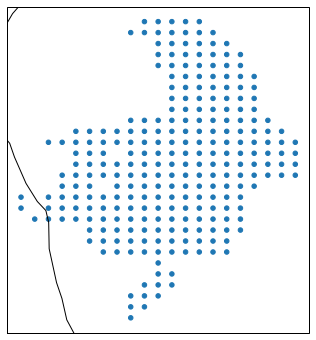

In [29]:
plot1 = plot_scatter(sdf, date)

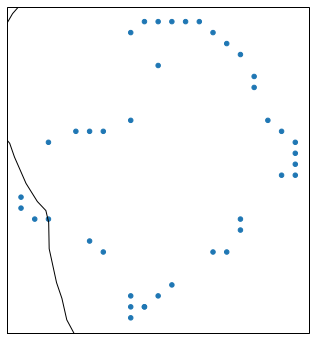

In [30]:
convexShapeScatter = plot_scatter(pdf, date)

transforming lon points > 60 to negative plane


/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


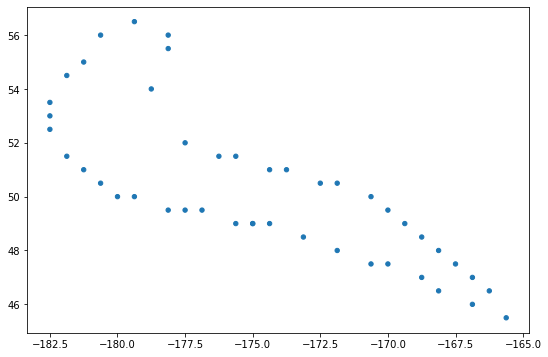

In [32]:
purp = get_perim_df(df, idx=19, buffer=0)

fig = plt.figure(figsize=(9,6))
x = purp['lon'].values
y = purp['lat'].values
z = purp['shape'].values
ax = plt.axes()
ax.scatter(x, y, z)

#purpScat = plot_scatter(purp, '')